In [46]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import re
from emot.emo_unicode import UNICODE_EMO, EMOTICONS

import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline

import spacy
import en_core_web_sm
import string

from wordcloud import WordCloud

import collections
import matplotlib.cm as cm
import numpy as np
from matplotlib import rcParams

from sklearn.metrics import f1_score, classification_report, accuracy_score


from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [47]:
class Task:
    def __init__(self,task):
        self.task=task
        self.nlp = en_core_web_sm.load()

    def load_dataset(self):
        if(self.task=='hate'):
            path='hate/'
            self.labels=[0,1]
            self.labels_info=["Non Hate","Hate"]
        elif(self.task=='offensive'):
            path='offensive/'
            self.labels=[0,1]
            self.labels_info=["Non Offensive","Offensive"]
        elif(self.task=='sentiment'):
            path='sentiment/'
            self.labels=[0,1,2]
            self.labels_info=["Negative","Neutral","Positive"]
        else:
            raise Exception("No such task")
        with open(path+"train_text.txt","r", encoding="utf8") as f:
            train_text=f.read()
        with open(path+"train_labels.txt","r", encoding="utf8") as f:
            train_labels=f.read()
        with open(path+"test_text.txt","r", encoding="utf8") as f:
            test_text=f.read()
        with open(path+"test_labels.txt","r", encoding="utf8") as f:
            test_labels=f.read()
        with open(path+"val_text.txt","r", encoding="utf8") as f:
            val_text=f.read()
        with open(path+"val_labels.txt","r", encoding="utf8") as f:
            val_labels=f.read() 
            
        train_text=train_text.split("\n")
        train_labels=train_labels.split("\n")

        train_text=train_text[:-1]
        train_labels=train_labels[:-1]


        data={"text":train_text,"label":train_labels}

        self.train_df=pd.DataFrame(data,columns=["text","label"])


        test_text=test_text.split("\n")
        test_labels=test_labels.split("\n")

        test_text=test_text[:-1]
        test_labels=test_labels[:-1]


        data={"text":test_text,"label":test_labels}

        self.test_df=pd.DataFrame(data,columns=["text","label"])


        val_text=val_text.split("\n")
        val_labels=val_labels.split("\n")

        val_text=val_text[:-1]
        val_labels=val_labels[:-1]


        data={"text":val_text,"label":val_labels}

        self.val_df=pd.DataFrame(data,columns=["text","label"])
        
        print("Data loaded successfully")
    def print_shape(self):
        print("Training Data Shape")
        print(self.train_df.shape)
        
        print("Validation Data Shape")
        print(self.val_df.shape)
        
        print("Testing Data Shape")
        print(self.test_df.shape)
        
    def show_train_label_dist(self):
        self.train_df['label'].value_counts().plot(kind='barh')
        
#     def initial_preprocess(self,text):
#         processed_text = []
#         text = text.lower()
#         text = re.sub(r'((www\.[\S]+)|(https?://[\S]+))', ' URL ', text)
#         text = re.sub(r'\brt\b', '', text)
#         text = re.sub(r'\.{2,}', ' ', text)
#         text = text.strip(' "\'')
#         text = re.sub(r'\s+', ' ', text)
#         words = text.split()

#         for word in words:
#             word = word.strip('\'"?!,.():;')
#             word = re.sub(r'(.)\1+', r'\1\1', word)
#             word = re.sub(r'(-|\')', '', word)
#             if (re.search(r'^[a-zA-Z][a-z0-9A-Z\._]*$', word) is not None):
#                 processed_text.append(word)

#         return ' '.join(processed_text)
    
    
    
        
    def preprocess(self):
        
        print("Preprocessing Dataset...")
        
        self.train_df=self.train_df[self.train_df.text==self.train_df.text]
        self.val_df=self.val_df[self.val_df.text==self.val_df.text]
        self.test_df=self.test_df[self.test_df.text==self.test_df.text]
        
        self.train_df["text"]=self.train_df["text"].apply(lambda x: str(x).lower())
        self.train_df["text"]=self.train_df["text"].apply(lambda x: self.convert_emoticons(str(x)))
        self.train_df["text"]=self.train_df["text"].apply(lambda x: self.convert_emojis(str(x)))
        
        self.val_df["text"]=self.val_df["text"].apply(lambda x: str(x).lower())
        self.val_df["text"]=self.val_df["text"].apply(lambda x: self.convert_emoticons(str(x)))
        self.val_df["text"]=self.val_df["text"].apply(lambda x: self.convert_emojis(str(x)))
        
        self.test_df["text"]=self.test_df["text"].apply(lambda x: str(x).lower())
        self.test_df["text"]=self.test_df["text"].apply(lambda x: self.convert_emoticons(str(x)))
        self.test_df["text"]=self.test_df["text"].apply(lambda x: self.convert_emojis(str(x)))
        
        self.train_df["hashtags"]=self.train_df["text"].apply(lambda x: ' '.join(self.get_all_hashtags(str(x))))
        self.train_df["text"]=self.train_df["text"].apply(lambda x: self.hashtag_handling(str(x)))
        
        self.val_df["hashtags"]=self.val_df["text"].apply(lambda x: ' '.join(self.get_all_hashtags(str(x))))
        self.val_df["text"]=self.val_df["text"].apply(lambda x: self.hashtag_handling(str(x)))
        
        self.test_df["hashtags"]=self.test_df["text"].apply(lambda x: ' '.join(self.get_all_hashtags(str(x))))
        self.test_df["text"]=self.test_df["text"].apply(lambda x: self.hashtag_handling(str(x)))
        
        self.train_df["text"]=self.train_df["text"].apply(lambda x:self.expand_contractions(x))
        self.val_df["text"]=self.val_df["text"].apply(lambda x:self.expand_contractions(x))
        self.test_df["text"]=self.test_df["text"].apply(lambda x:self.expand_contractions(x))
        
        
        
        
        self.train_df["text"] =self.train_df["text"].apply(lambda x: self.remove_handles(str(x)))
        self.train_df["text"] =self.train_df["text"].apply(lambda x: re.sub('\w*\d\w*','', x))
        self.train_df["text"] =self.train_df["text"].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))
        self.train_df["text"] =self.train_df["text"].str.replace("[^a-zA-Z#]", " ")
        self.train_df["text"] =self.train_df["text"].apply(lambda x: re.sub(' +',' ',x))
        self.train_df["text"]=self.train_df["text"].apply(lambda x: self.nlp_ner_removal(str(x)))
        self.train_df["text"]=self.train_df["text"].apply(lambda x: self.nlp_preprocess(str(x)))       
        self.train_df["text"] =self.train_df["text"].apply(lambda x: self.remove_short_words(str(x)))
        
        self.val_df["text"] =self.val_df["text"].apply(lambda x: self.remove_handles(str(x)))
        self.val_df["text"] =self.val_df["text"].apply(lambda x: re.sub('\w*\d\w*','', x))
        self.val_df["text"] =self.val_df["text"].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))
        self.val_df["text"] =self.val_df["text"].str.replace("[^a-zA-Z#]", " ")
        self.val_df["text"] =self.val_df["text"].apply(lambda x: re.sub(' +',' ',x))
        self.val_df["text"]=self.val_df["text"].apply(lambda x: self.nlp_ner_removal(str(x)))
        self.val_df["text"]=self.val_df["text"].apply(lambda x: self.nlp_preprocess(str(x)))
        self.val_df["text"] =self.val_df["text"].apply(lambda x: self.remove_short_words(str(x)))
        
        self.test_df["text"] =self.test_df["text"].apply(lambda x: self.remove_handles(str(x)))
        self.test_df["text"] =self.test_df["text"].apply(lambda x: re.sub('\w*\d\w*','', x))
        self.test_df["text"] =self.test_df["text"].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))
        self.test_df["text"] =self.test_df["text"].str.replace("[^a-zA-Z#]", " ")
        self.test_df["text"] =self.test_df["text"].apply(lambda x: re.sub(' +',' ',x))
        self.test_df["text"]=self.test_df["text"].apply(lambda x: self.nlp_ner_removal(str(x)))
        self.test_df["text"]=self.test_df["text"].apply(lambda x: self.nlp_preprocess(str(x)))
        self.test_df["text"] =self.test_df["text"].apply(lambda x: self.remove_short_words(str(x)))
        
        
        
        
        
        self.train_df["label"]=pd.to_numeric(self.train_df["label"])
        self.val_df["label"]=pd.to_numeric(self.val_df["label"])
        self.test_df["label"]=pd.to_numeric(self.test_df["label"])
        
        print("Preprocessing completed successfully!")
        
        
    def train_exploratory_analysis(self):
        for label in self.labels:
            print("Analysis for "+self.labels_info[self.labels.index(label)])
            words = ' '.join([text for text in self.train_df['text'][self.train_df['label'] == label]])
            wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(words)
        
        

            plt.figure(figsize=(10, 7))
            plt.imshow(wordcloud, interpolation="bilinear")
            plt.axis('off')
            plt.show()


            counted_words = collections.Counter(words.split(" "))

            words = []
            counts = []
            for letter, count in counted_words.most_common(20):
                words.append(letter)
                counts.append(count)

            colors = cm.rainbow(np.linspace(0, 1, 20))
            rcParams['figure.figsize'] = 20, 10

            plt.title('Top words in the '+self.labels_info[self.labels.index(label)]+' tweets vs their count')
            plt.xlabel('Count')
            plt.ylabel('Words')
            plt.barh(words, counts, color=colors)
            plt.show()
            
            print()
        
        
        
        
    def convert_emojis(self,text):
        for emot in UNICODE_EMO:
            text = text.replace(emot, " ".join(UNICODE_EMO[emot].replace(",","").replace(":","").replace("_"," ").split()))
        return text
    def convert_emoticons(self,text):
        for emot in EMOTICONS:
            text = re.sub(u'('+emot+')', " ".join(EMOTICONS[emot].replace(",","").replace("_"," ").split()), text)
        return text
    def get_all_hashtags(self,input_txt):
        input_txt=input_txt.replace("#"," #")
        hashtags = [tag.strip("#") for tag in input_txt.split() if tag.startswith("#")]

        return hashtags


    def hashtag_handling(self,input_txt):
        hashtags=self.get_all_hashtags(input_txt)
        for tag in hashtags:
            input_txt=input_txt.replace("#"+tag,tag)
        return input_txt
    
    def expand_contractions(self,text):
        contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

        # Regular expression for finding contractions
        contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))
        def replace(match):
            return contractions_dict[match.group(0)]
        return contractions_re.sub(replace, text)
    def remove_handles(self,input_txt):
        r = re.findall("@[\w]*", input_txt)
        for i in r:
            input_txt = re.sub(i, '', input_txt)

        return input_txt 

    def remove_short_words(self,input_txt):
        return ' '.join([w for w in input_txt.split() if len(w)>3])
    def nlp_ner_removal(self,input_txt):
        if(input_txt==input_txt): 
            doc = self.nlp(input_txt)
            for item in [(ent.text, ent.label_) for ent in doc.ents]:
                    input_txt=input_txt.replace(item[0],'')
        return input_txt
    def nlp_preprocess(self,input_txt):
        if(input_txt==input_txt): 
            doc = self.nlp(input_txt)
            
            

            spacy_words = [t.lemma_ for t in doc if ((t.text in self.nlp.vocab) and (not t.is_stop) and (t.pos_ != 'PUNCT'))]
            sentence=" ".join(spacy_words)
            return sentence
        
    def model_nb(self):
        X_train = self.train_df.text.values
        y_train = self.train_df.label.values
        
        X_val = self.val_df.text.values
        y_val = self.val_df.label.values
        
        X_test = self.test_df.text.values
        y_test = self.test_df.label.values

        
        tf_idf = TfidfVectorizer(smooth_idf=False)
        
        X_train_tfidf = tf_idf.fit_transform(X_train)
        
        X_val_tfidf = tf_idf.transform(X_val)
        X_test_tfidf = tf_idf.transform(X_test)
        
        
        
        
        model = MultinomialNB(alpha=1.8)
        
        
        model.fit(X_train_tfidf,y_train)
        
        predictions = model.predict(X_val_tfidf)
        print("Naive Bayes - Validation")
        print()
        
        print("acc:",accuracy_score(predictions, y_val)*100)
        print('f1-macro:',f1_score(y_val, predictions, average='macro'))
        print()
        
        predictions = model.predict(X_test_tfidf)
        print("Naive Bayes - Testing")
        print()
        
        print("acc:",accuracy_score(predictions, y_test)*100)
        print('f1-macro:',f1_score(y_test, predictions, average='macro'))
        print()
        
    def model_svm(self):
        X_train = self.train_df.text.values
        y_train = self.train_df.label.values
        
        X_val = self.val_df.text.values
        y_val = self.val_df.label.values
        
        X_test = self.test_df.text.values
        y_test = self.test_df.label.values

        
        tf_idf = TfidfVectorizer(smooth_idf=False)
        
        X_train_tfidf = tf_idf.fit_transform(X_train)
        
        X_val_tfidf = tf_idf.transform(X_val)
        X_test_tfidf = tf_idf.transform(X_test)
        
        
        model = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
        
        model.fit(X_train_tfidf,y_train)
        
        predictions = model.predict(X_val_tfidf)
        print("SVM - Validation")
        print()
        
        print("acc:",accuracy_score(predictions, y_val)*100)
        print('f1-macro:',f1_score(y_val, predictions, average='macro'))
        print()
        
        predictions = model.predict(X_test_tfidf)
        print("SVM - Testing")
        print()
        
        print("acc:",accuracy_score(predictions, y_test)*100)
        print('f1-macro:',f1_score(y_test, predictions, average='macro'))
        print()
        

Data loaded successfully
Training Data Shape
(9000, 2)
Validation Data Shape
(1000, 2)
Testing Data Shape
(2970, 2)
Preprocessing Dataset...
Preprocessing completed successfully!
Training Data Shape
(9000, 3)
Validation Data Shape
(1000, 3)
Testing Data Shape
(2970, 3)
Analysis for Non Hate


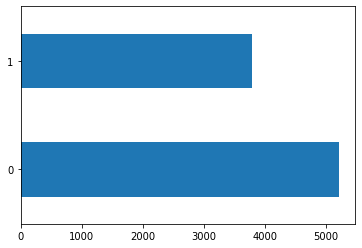

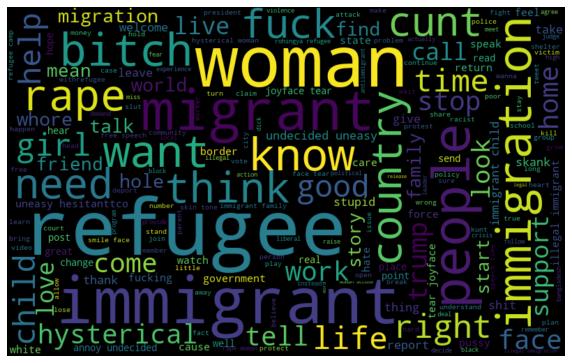

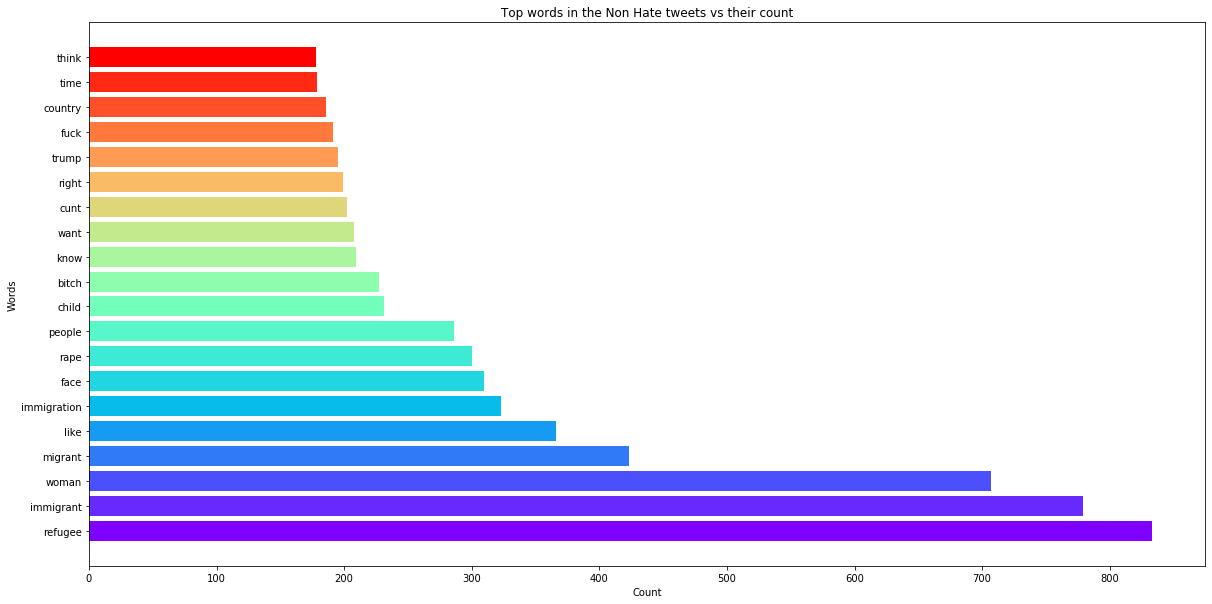


Analysis for Hate


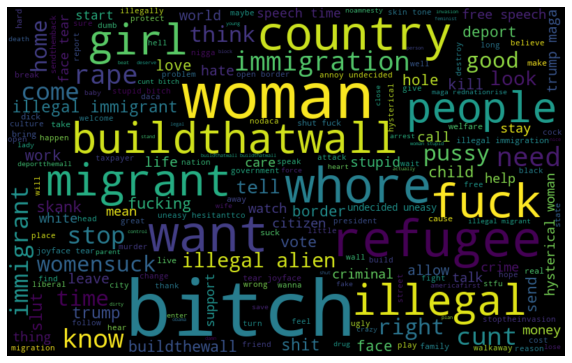

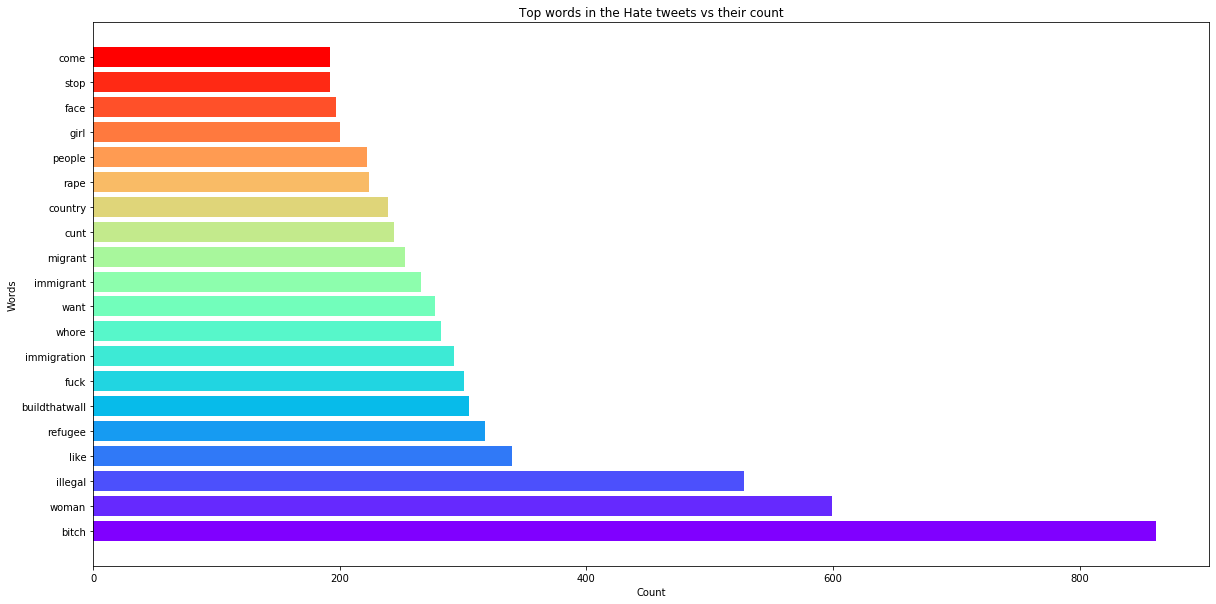


Naive Bayes - Validation

acc: 69.39999999999999
f1-macro: 0.6691620068243445

Naive Bayes - Testing

acc: 54.006734006734
f1-macro: 0.536993331458643

SVM - Validation

acc: 67.80000000000001
f1-macro: 0.6681835419036785

SVM - Testing

acc: 52.18855218855219
f1-macro: 0.5027926796142876



In [48]:
task=Task("hate")
task.load_dataset()
task.print_shape()
task.preprocess()
task.print_shape()
task.show_train_label_dist()
task.train_exploratory_analysis()
task.model_nb()
task.model_svm()

Data loaded successfully
Training Data Shape
(11916, 2)
Validation Data Shape
(1324, 2)
Testing Data Shape
(860, 2)
Preprocessing Dataset...
Preprocessing completed successfully!
Training Data Shape
(11916, 3)
Validation Data Shape
(1324, 3)
Testing Data Shape
(860, 3)
Analysis for Non Offensive


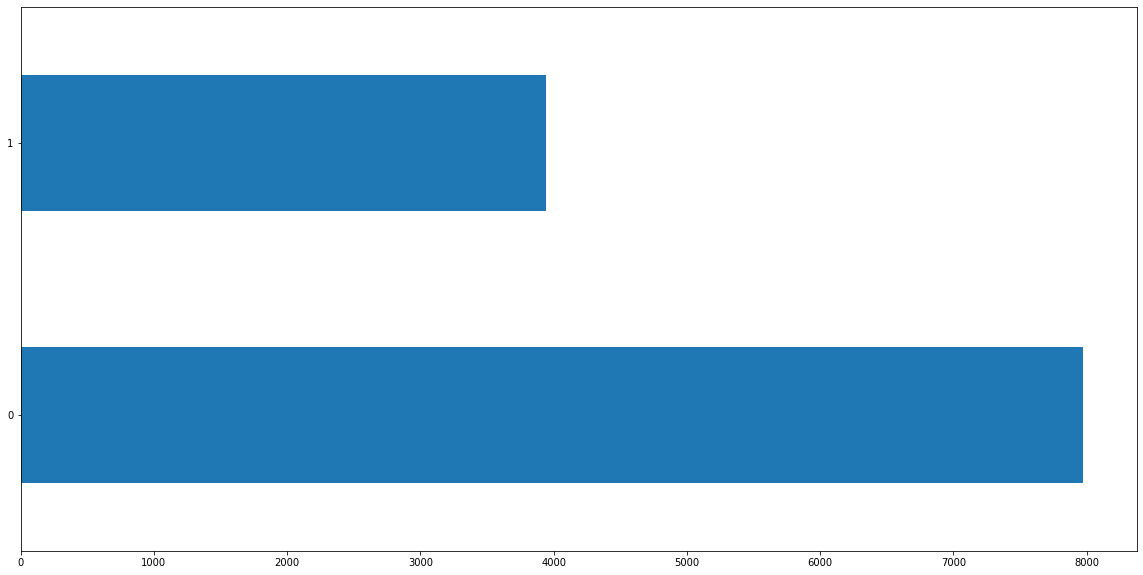

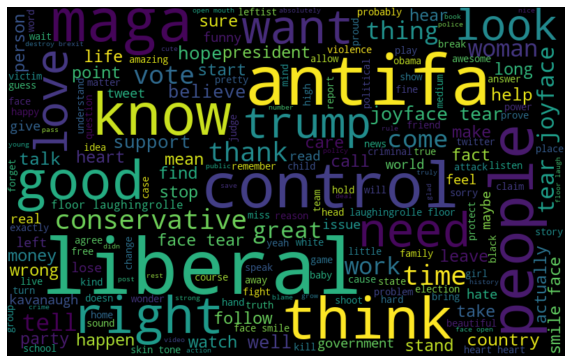

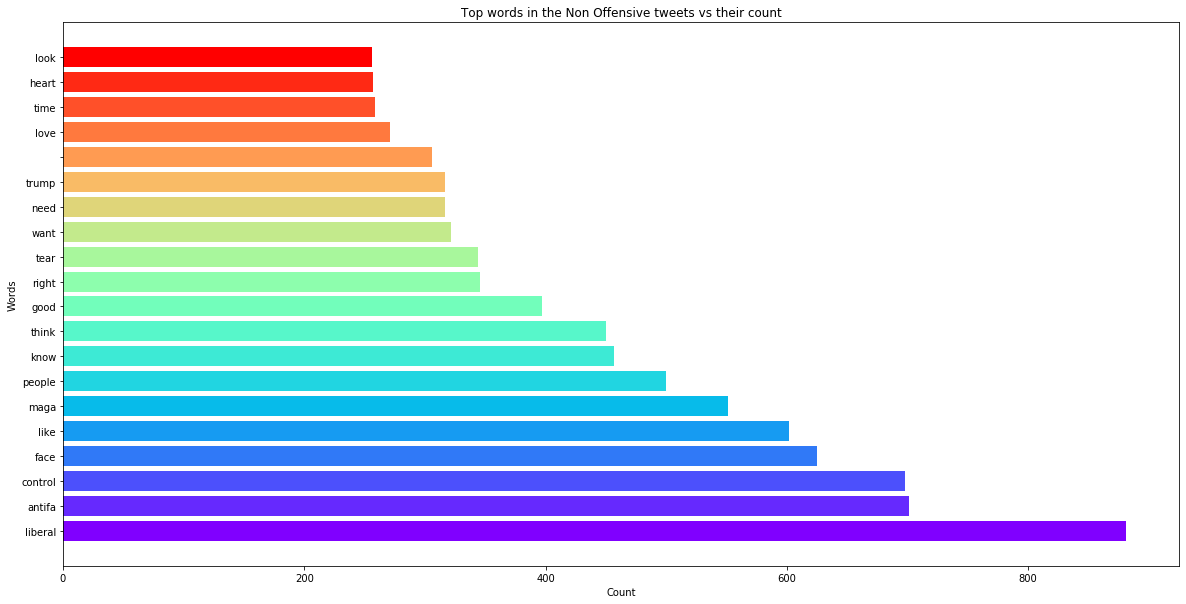


Analysis for Offensive


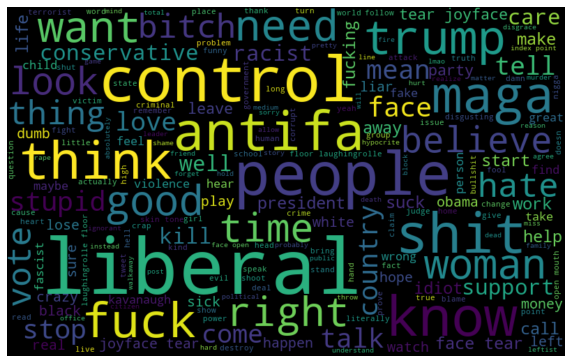

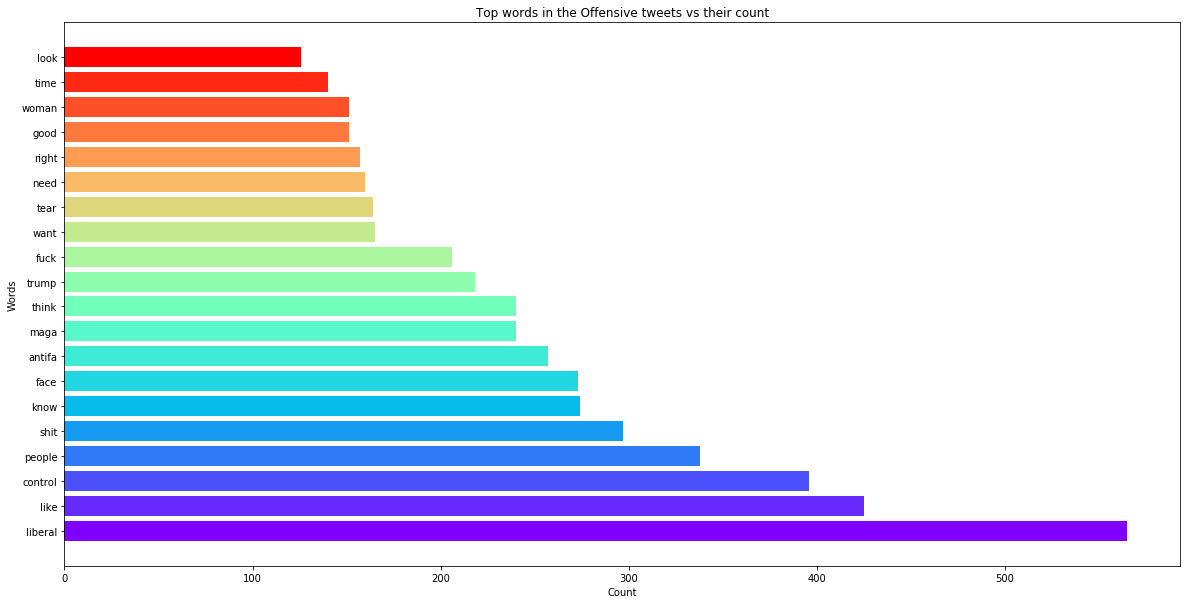


Naive Bayes - Validation

acc: 72.05438066465257
f1-macro: 0.5810413245758073

Naive Bayes - Testing

acc: 76.74418604651163
f1-macro: 0.582945375543141

SVM - Validation

acc: 75.52870090634441
f1-macro: 0.6882396546461431

SVM - Testing

acc: 81.51162790697674
f1-macro: 0.7235201941060507



In [49]:
task=Task("offensive")
task.load_dataset()
task.print_shape()
task.preprocess()
task.print_shape()
task.show_train_label_dist()
task.train_exploratory_analysis()
task.model_nb()
task.model_svm()

Data loaded successfully
Training Data Shape
(45615, 2)
Validation Data Shape
(2000, 2)
Testing Data Shape
(12284, 2)
Preprocessing Dataset...
Preprocessing completed successfully!
Training Data Shape
(45615, 3)
Validation Data Shape
(2000, 3)
Testing Data Shape
(12284, 3)
Analysis for Negative


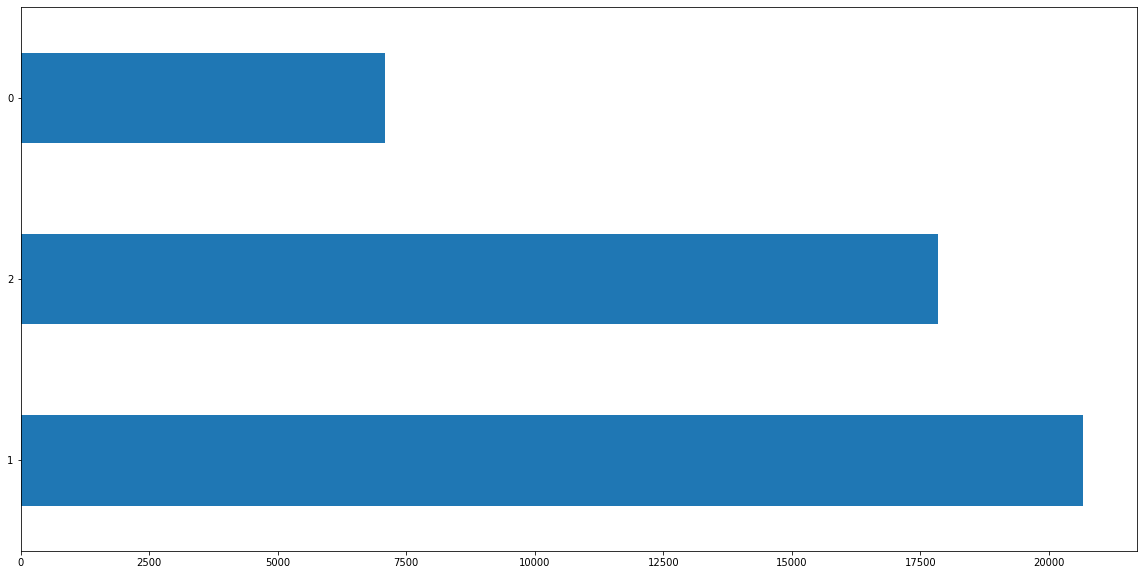

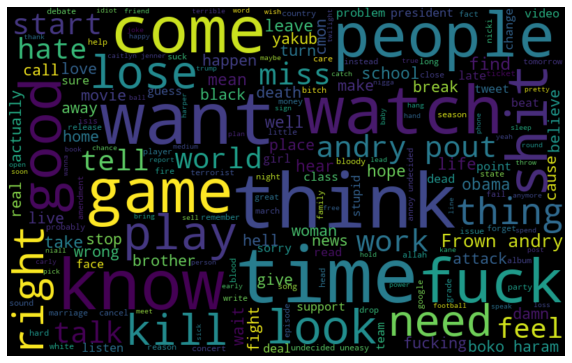

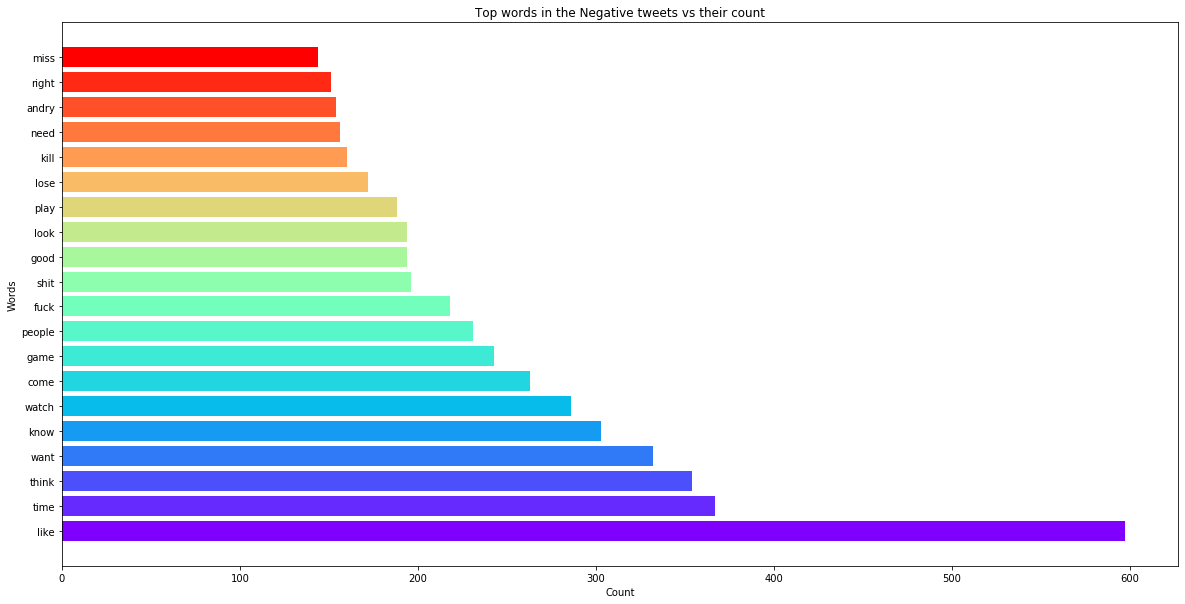


Analysis for Neutral


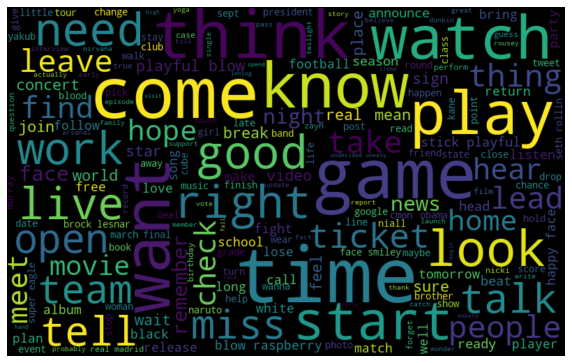

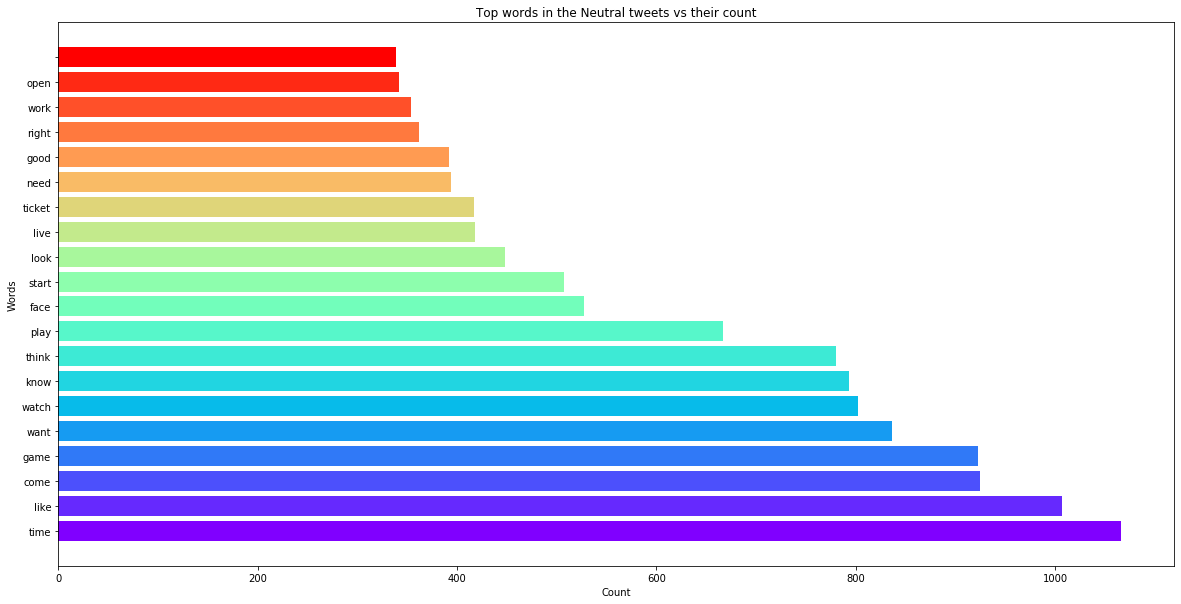


Analysis for Positive


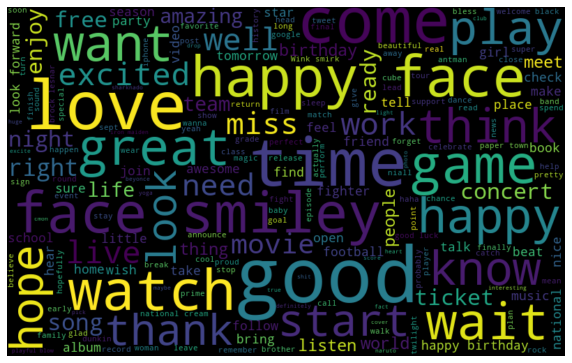

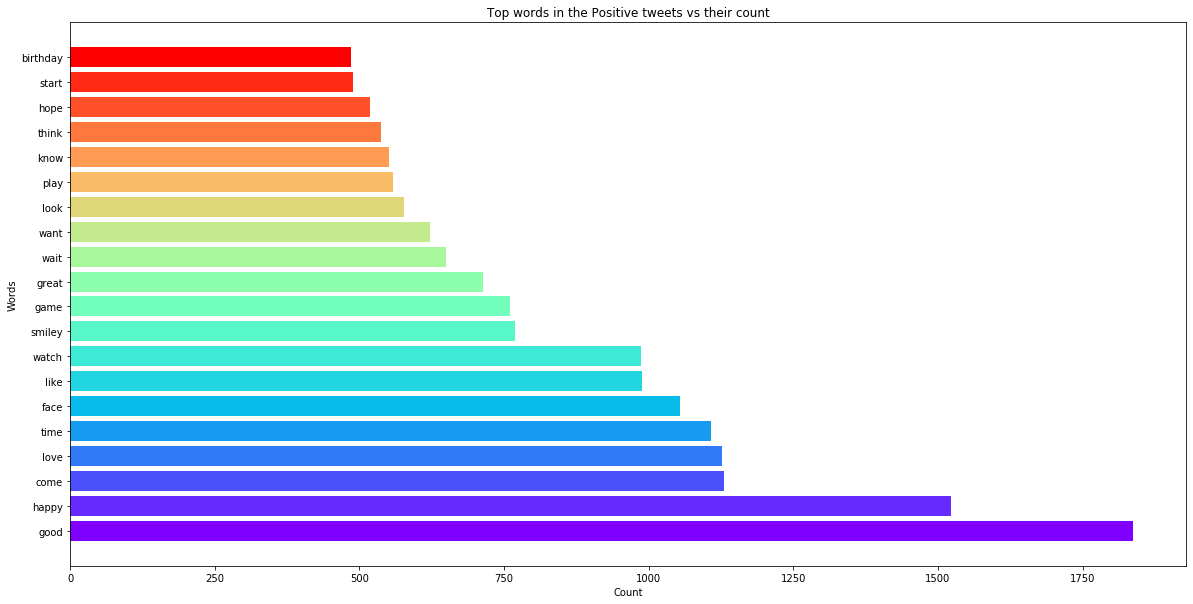


Naive Bayes - Validation

acc: 59.599999999999994
f1-macro: 0.48261319143624465

Naive Bayes - Testing

acc: 52.75154672745034
f1-macro: 0.4373305524360878

SVM - Validation

acc: 63.7
f1-macro: 0.5873546814573821

SVM - Testing

acc: 57.1393682839466
f1-macro: 0.5151403438072131



In [50]:
task=Task("sentiment")
task.load_dataset()
task.print_shape()
task.preprocess()
task.print_shape()
task.show_train_label_dist()
task.train_exploratory_analysis()
task.model_nb()
task.model_svm()